导入库

使用的数据是noaa的olr-daily资料

In [ ]:
import cmaps
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import netCDF4 as nc
import os
import xarray as xr
import glob
import sys
import pickle
import datetime
import pandas as pd
import calendar
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import warnings
from scipy.signal import butter, freqz, filtfilt
warnings.filterwarnings("ignore", category=FutureWarning)


In [152]:
__path__ = r'I:/olr.day.mean.nc'
time_slice = ['1979-01-01','2018-12-31']
time_start = 1979
time_end   = 2018
ds   = xr.open_dataset(__path__).sel(lat=slice(60, -60), lon=slice(60, 300),
                                     time=slice(time_slice[0],time_slice[1])
                                     ).sortby('lat') 
olr  = ds.olr
lon  = olr.lon.values
lat  = olr.lat.values
time = olr.time.values
olr

<xarray.DataArray 'olr' (time: 14610, lat: 49, lon: 97)> Size: 278MB
[69441330 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 388B 60.0 62.5 65.0 67.5 ... 292.5 295.0 297.5 300.0
  * lat      (lat) float32 196B -60.0 -57.5 -55.0 -52.5 ... 52.5 55.0 57.5 60.0
  * time     (time) datetime64[ns] 117kB 1979-01-01 1979-01-02 ... 2018-12-31
Attributes:
    units:         W/m^2
    var_desc:      Outgoing Longwave Radiation
    precision:     2
    dataset:       NOAA Interpolated OLR
    level_desc:    Other
    statistic:     Mean
    parent_stat:   Individual Obs
    valid_range:   [  0. 500.]
    long_name:     Daily Mean OLR
    actual_range:  [ 64.75 344.5 ]

## 气候态空间的空间分布图

Text(0.5, 1.0, 'OLR climatology (1979-2018)')

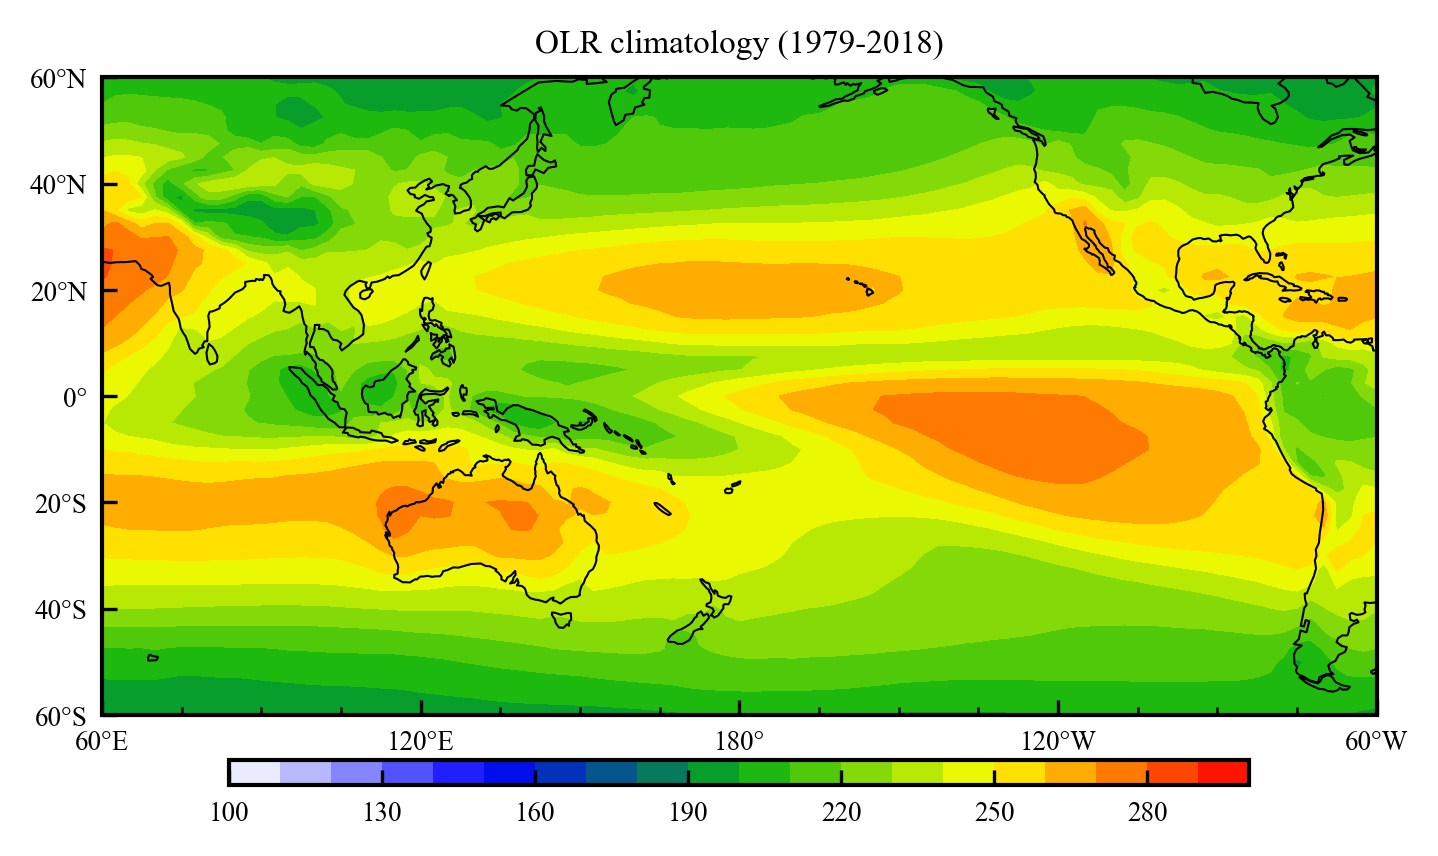

In [153]:
olr_clm = olr.mean(dim='time')
olr_std = olr.std(dim='time')
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['ytick.minor.visible'] =  False
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1
plt.rcParams['font.family'] = 'Times New Roman'

def set_ax(ax):
    ax.set_xticks(np.arange(lon.min(), lon.max(), 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-40, 41, 10), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.xaxis.set_major_locator(mticker.MultipleLocator(60))
    ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(4))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(20))
    ax.coastlines(color='k', linewidth=0.5) 

plt.rcParams.update({'font.size': 6.5})  # Set font size for all

fig, ax = plt.subplots(1, 1, figsize=(5,4), dpi=300,sharex=True,sharey=True,subplot_kw={'projection': ccrs.PlateCarree(180)})
plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.15, wspace=0.1, hspace=0.15)
cb = ax.contourf(lon, lat, olr_clm, levels=np.linspace(100, 300, 21), cmap=cmaps.WhBlGrYeRe, extend='neither',transform=ccrs.PlateCarree())   
set_ax(ax)
plt.colorbar(cb, ax=ax, orientation='horizontal', pad=0.05, aspect=40, shrink=0.8)
plt.title(f'OLR climatology ({time_start}-{time_end})', fontsize=8)


## 分离每个场变量的异常



去除时间气候态平均

低通滤波，去除任何周期大于20天的变率

In [154]:
def butter_lowpass_filter(data,cut, fs, order=4):
    """
    使用Butterworth低通滤波器滤掉大于给定截止频率的信号。
    :param data: 输入信号数据
    :param cutoff_freq: 截止频率
    :param fs: 采样频率
    :return: 滤波后的信号
    """
    nyq = 0.5 * fs      # 奈奎斯特频率
    cut = cut / nyq     # 归一化截止频率
    b, a = butter(order, cut, btype='lowpass') # # 设计一个4阶Butterworth低通滤波器
    return filtfilt(b, a, data)


def remove_20d_from_daily_data(x, fs=1, cutoff=1/20):
    # x: input data (time, lat, lon)
    # fs = 1-->1 samples per day 
    # cutoff = 1/10 (1/day)-->cut off signals with period longer than 10 day
    dimsize = np.size(np.shape(x))
    nt = np.size(x,0)
    n1 = np.size(x,1)  # lat    
    n2 = np.size(x,2)  # lon
    for i1 in range(0,n1):
        for i2 in range(0,n2):
            if i1 == 0 and i2 == 0:
                x_m = np.empty([nt,n1,n2]) 
            x_m[:,i1,i2] = butter_lowpass_filter(x[:,i1,i2], cutoff, fs)
    
    return x_m
olr_ano = olr - olr_clm
olr_filter = remove_20d_from_daily_data(olr_ano.values, fs=1, cutoff=1/20)


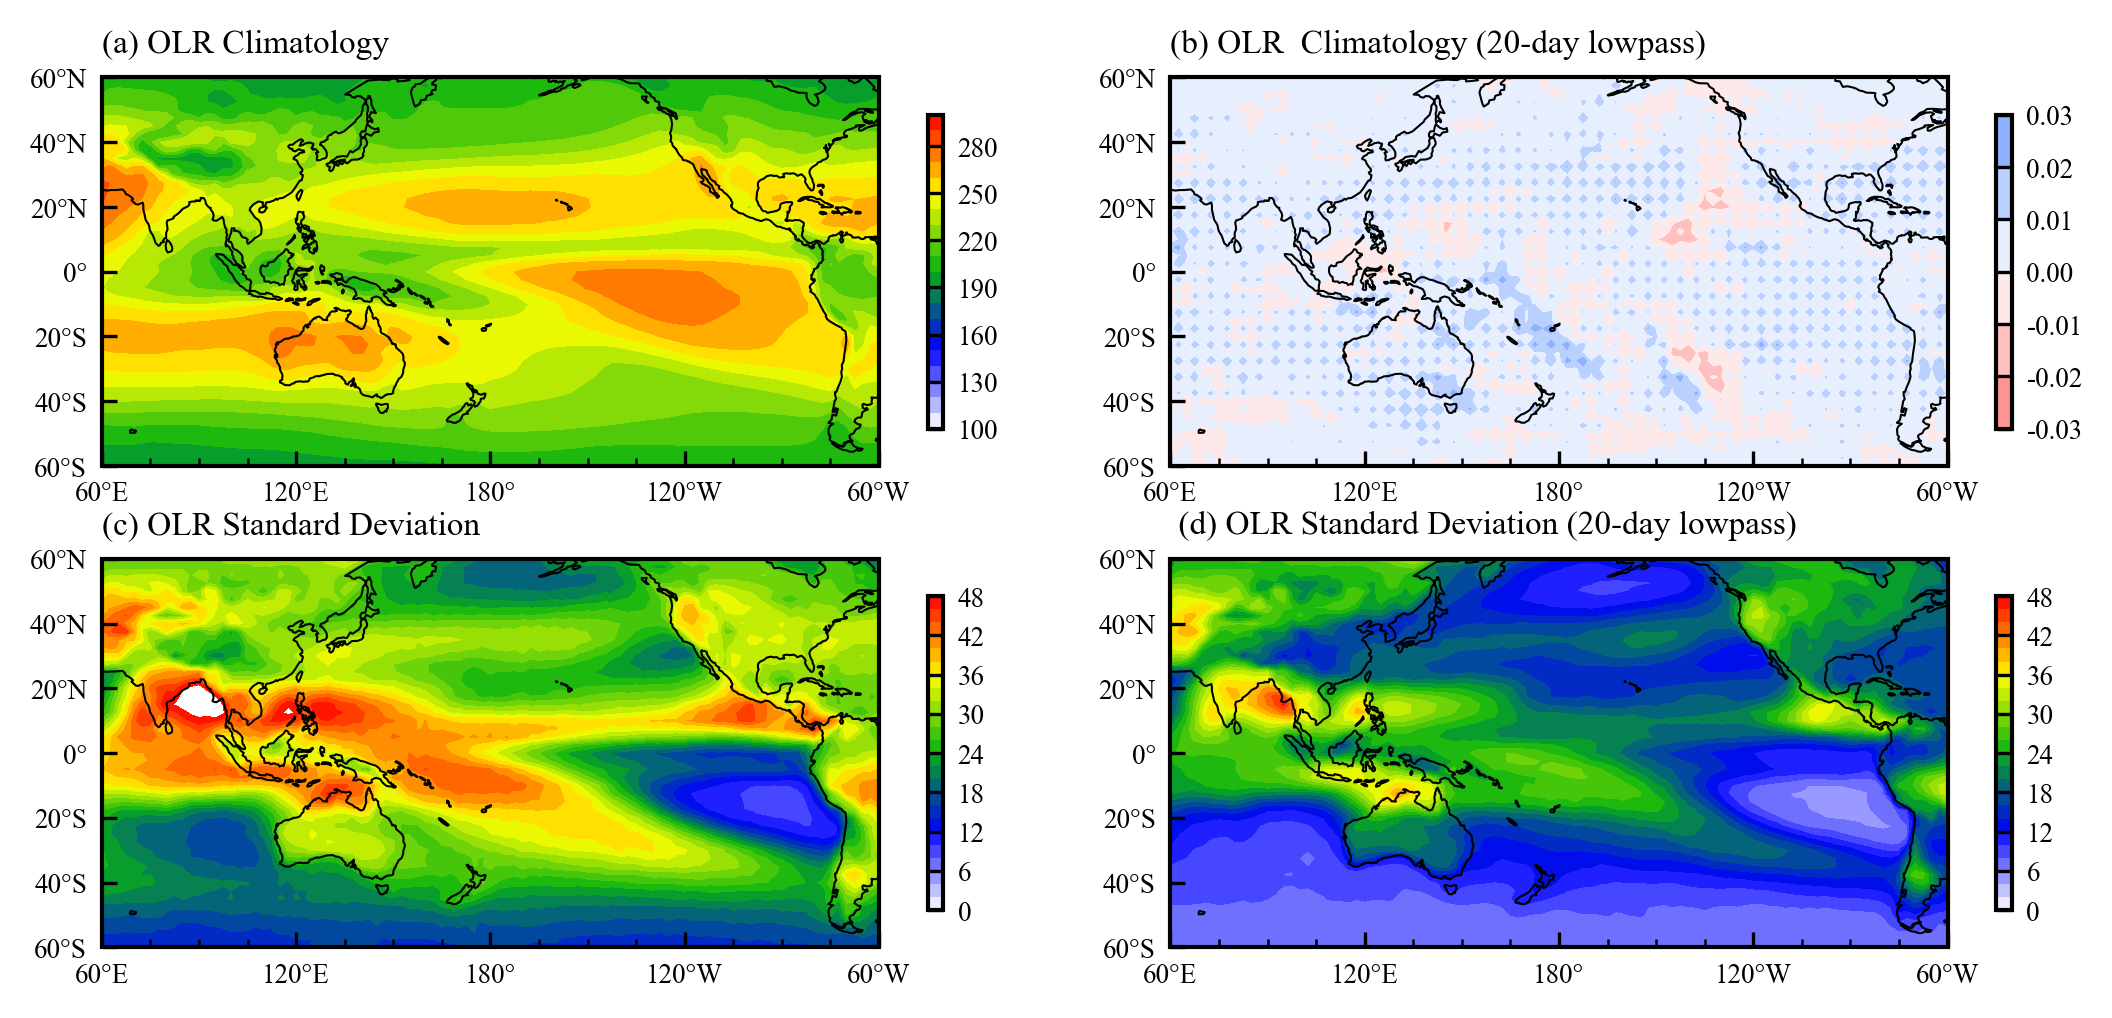

In [155]:
def set_ax(ax):
    ax.set_xticks(np.arange(lon.min(), lon.max(), 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-40, 41, 10), crs=ccrs.PlateCarree())
    ax.set_extent([lon.min(), lon.max(), -60, 60], crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.xaxis.set_major_locator(mticker.MultipleLocator(60))
    ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(4))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(20))
    ax.coastlines(color='k', linewidth=0.5) 

myCmap1 = LinearSegmentedColormap.from_list("", ['#ff7f7f','#ff8c8c','#ff9899','#fea5a5','#feb2b2','#febfbf','#fecbcc','#fed8d9','#fde5e5','#fdf1f2','#fdfeff','#f0f5ff','#e3ecff','#d5e3ff','#c8daff','#bbd1ff','#aec7ff','#a1beff','#93b5ff','#86acff','#79a3ff'])


def plot_contour(ax, data, levels, cmap, transform, title, **kwargs):
    cb = ax.contourf(lon, lat, data, levels=levels, cmap=cmap, extend='neither', transform=transform)
    plt.colorbar(cb, ax=ax, orientation='vertical', shrink=0.75, aspect=20, pad=0.05)
    ax.set_title(title, fontsize=8,loc='left')
    set_ax(ax)

fig, ax = plt.subplots(2, 2, figsize=(8, 4), dpi=300, sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree(180)})
plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.15, wspace=0.1, hspace=0.15)

plot_contour(ax[0, 0], olr_clm, np.linspace(100, 300, 21), cmaps.WhBlGrYeRe, ccrs.PlateCarree(), '(a) OLR Climatology')
plot_contour(ax[0, 1], np.mean(olr_filter , axis=0),  np.linspace(-0.03, 0.03, 7), myCmap1, ccrs.PlateCarree(), '(b) OLR  Climatology (20-day lowpass)')
plot_contour(ax[1, 0], olr_std, np.linspace(0, 48, 25), cmaps.WhBlGrYeRe, ccrs.PlateCarree(), '(c) OLR Standard Deviation')
plot_contour(ax[1, 1], np.std(olr_filter , axis=0), np.linspace(0, 48, 25), cmaps.WhBlGrYeRe, ccrs.PlateCarree(), ' (d) OLR Standard Deviation (20-day lowpass)')

## 经向投影


这里挑选热带区域(10°S-10°N),将变量投影到kelvin波的经向结构特征上-以赤道处的最大值和随纬度的指数衰减为标志。

这种经向结构的精确数学表示如下所示：



$$X_P=\int_{-\varphi_{\max}}^{\varphi_{\max}}X'\times w(\varphi)\times e^{-\left(\frac\varphi{\varphi(\Omega)}\right)^2}d\varphi,$$

X为变量，$\phi$表示纬度，$\varphi_0$表示kws的经向尺度，一般设置为9°，$\varphi_{\max}$为10°，权重函数定义如下所示：


$$
w(\varphi)=\left\{\begin{array}{ll}
1, & |\varphi| \leq 10^{\circ} \\
0, & \text { otherwise }
\end{array}\right.
$$


权重函数的意思就是说，在热带区域是1，其他区域为0


In [156]:
def meridional_projection(inputdata,lat_0=9, lat_tropics = 10,omega = 0):
    
    KW_coef = np.exp( -(lat/(2*lat_0))**2)
    if omega  == 0:
        omega = np.where(np.abs(lat)>lat_tropics,0,1)
    else:
        omega = np.where(np.abs(lat)>lat_tropics,1,0)
    V = inputdata
    Vdim = np.size(np.shape(V))
    KW_filt = KW_coef*omega
    SUM = np.sum(KW_filt)

    if Vdim ==3:            # Variable is (time, lat, lon)
        nt   = np.size(V,0)
        nlon = np.size(V,2)
        V_T = np.transpose(V.data, (0,2,1)) # now, Variable is (time, lon, lat)
        del V 
        
    if np.sum(np.isnan(V_T))==0:
        V_projected = np.inner(V_T, KW_filt)/SUM
        del V_T
    else:
        if Vdim == 3 :
            KW_filt_large = np.tile(KW_filt, (nt, nlon, 1))
        
        if Vdim != 4:
            KW_filt_mask = np.ma.array(KW_filt_large, mask=np.isnan(V_T))
            del KW_filt_large
            Vsum = np.nansum(V_T*KW_filt_mask, Vdim-1)
            del V_T
            KWsum = np.nansum(KW_filt_mask, Vdim-1)
            del KW_filt_mask
            V_projected  = Vsum/KWsum
            del Vsum, KWsum

    return V_projected

olr_meridional = meridional_projection(olr_filter)


绘制投影结果，得到的是一个二维数组，timexlon，绘制填色图即为Hovmoller图


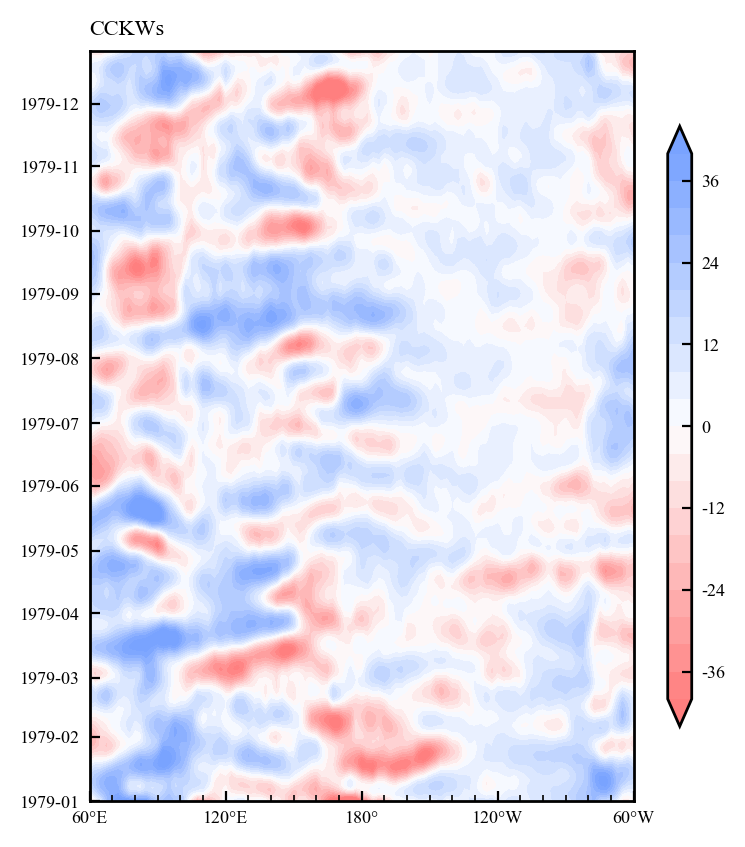

In [157]:
fig, ax = plt.subplots(1, 1, figsize=(4, 5), dpi=200, sharex=True, sharey=True)
plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.15, wspace=0.1, hspace=0.15)
cb = ax.contourf(lon, time[0:360],olr_meridional[0:360,:], levels=np.linspace(-40,40,21), extend='both',cmap=myCmap1)
plt.colorbar(cb, ax=ax, orientation='vertical', shrink=0.8, aspect=25, pad=0.05)
ax.set_title('CCKWs', fontsize=8,loc='left')

ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.xaxis.set_major_locator(mticker.MultipleLocator(60))
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(6))